- This will be useful to chat with documents such as Earnings Presentation that has a lot of pictures. 
- This will try to answer questions while bringing the relevant content from the original document as well.
[This](https://www.llamaindex.ai/blog/a-new-document-summary-index-for-llm-powered-qa-systems-9a32ece2f9ec) write up discusses the new document summary index for LLM-powered QA systems. In this notebook we are using SummaryIndex
# Imports

In [ ]:
%%time
# !pip install -U llama-index-callbacks-arize-phoenix

import nest_asyncio
import os
from dotenv import load_dotenv


nest_asyncio.apply()

# Load environment variables from .env file
load_dotenv()

# Access secret keys
PHOENIX_API_KEY = os.getenv('PHOENIX_API_KEY')
LLAMAPARSE_API_KEY = os.getenv('LLAMAPARSE_API_KEY')
OPENAI_API_KEY  = os.getenv('OPENAI_API_KEY')


CPU times: total: 15.6 ms
Wall time: 112 ms


# Get Data

In [2]:
%%time
from pathlib import Path
class CFG:
    reuse_data = True
    file_path = Path("data/rjf1q25.pdf")
    images_path = Path("data_images")

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
import requests

#create folders to store data, ignore error if the folder already exists
os.makedirs(name="data", exist_ok=True)

#this is optional. if a folder is not available during download. it will be created automatically
os.makedirs(name="data_images", exist_ok=True)

# url = "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf"
# url = "https://www.raymondjames.com/-/media/rj/dotcom/files/our-company/news-and-media/2025-press-releases/rjf20250129-1q-earnings.pdf"
url = "https://www.raymondjames.com/-/media/rj/dotcom/files/our-company/news-and-media/2025-press-releases/rjf20250129-1q-presentation.pdf"
#download the document
doc = requests.get(url=url)

if not CFG.file_path.is_file():
    with open(file=CFG.file_path, mode="wb") as f:
        #write the buffer to the iostream
        f.write(doc.content)
    print(f"{url} downloaded and saved to {CFG.file_path}")
else:
    print(f"Using already downloaded and saved file!!!")



# Set up embedding models

In [3]:
%%time
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

#one of the latest embedding models from OpenAI for applications requiring detailed semantic understanding and 
#large-scale embedding tasks. Cost effective too. This model creates embeddings with up to 3072 dimensions, 
#capturing more nuanced semantic meanings. 
embed_model = OpenAIEmbedding(model="text-embedding-3-large")

llm = OpenAI(model="gpt-40")

#Register the models as the default for LlamaIndex
from llama_index.core import Settings
Settings.embed_model = embed_model
Settings.llm = llm

print(f"Sucessfully setup models")

Sucessfully setup models
CPU times: total: 4.97 s
Wall time: 5.93 s


# Parse document using LlamaParse
- Llamaparse can extract text and images, using a multimodal LLM such as gpt-40. 
- For each PDF page, it returns a 
    - a markdown text with tables, headings, bullet points, etc
    - a rendered image (saved locally)

In [4]:
%%time

from llama_parse import LlamaParse

parser = LlamaParse(
    api_key=LLAMAPARSE_API_KEY,
    result_type="markdown", #markdown and text are available
    verbose=True,
    gpt4o_mode=True
)

print(f"Parsing document - {CFG.file_path}")
#get a list of "pages"
md_json_obj = parser.get_json_result(file_path=CFG.file_path)
#extract all pages
md_json_list = md_json_obj[0]["pages"]

print(f"Parsed {len(md_json_list)} pages from {CFG.file_path}")
print(f"Cost for the job is {md_json_obj[0]['job_metadata']}")


Parsing document - data\rjf1q25.pdf
Started parsing the file under job_id 63cc2d95-4b2a-4663-8cba-3261087c21d5
Parsed 27 pages from data\rjf1q25.pdf
Cost for the job is {'credits_used': 270.0, 'job_credits_usage': 270, 'job_pages': 27, 'job_auto_mode_triggered_pages': 0, 'job_is_cache_hit': False, 'credits_max': 1000}
CPU times: total: 797 ms
Wall time: 39.3 s


In [5]:
#Each page is split into different sections such as "md" that contains the markup content,
#"images" that contains images and its relevant position on that page
page_1 = md_json_list[0]
# print(page_1)

for k,v in page_1.items():
    print(k, v)

page 1
md NO_CONTENT_HERE
images [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
charts []
items [{'type': 'text', 'value': 'NO_CONTENT_HERE', 'md': 'NO_CONTENT_HERE'}]
status WARNING
links []
triggeredAutoMode False
parsingMode multimodal-openai-gpt4o
structuredData None
noStructuredContent True
noTextContent False


In [6]:
#access page 2's content
md_page2 = md_json_list[1]['md']
print(md_page2)

# Forward-looking statements

Certain statements made in this presentation and the associated conference call may constitute "forward-looking statements" under the Private Securities Litigation Reform Act of 1995. Forward-looking statements include information concerning future strategic objectives, business prospects, anticipated savings, financial results (including expenses, earnings, liquidity, cash flow and capital expenditures), industry or market conditions (including changes in interest rates and inflation), demand for and pricing of our products (including cash sweep and deposit offerings), anticipated timing and benefits of our acquisitions or divestitures, and our level of success in integrating acquired businesses, anticipated results of litigation, regulatory developments, and general economic conditions. In addition, words such as "believes," "expects," "anticipates," "intends," "plans," "estimates," "projects," "forecasts," and future or conditional verbs such as "will,"

In [7]:
%%time
from pathlib import Path
import shutil

if CFG.images_path.exists() and CFG.images_path.is_dir():
    shutil.rmtree(CFG.images_path)
    print(f"Folder '{CFG.images_path}' has been deleted.")

nodes_folder = Path("storage_nodes_summary")
if nodes_folder.exists() and nodes_folder.is_dir():
    shutil.rmtree(nodes_folder)
    print(f"Folder '{nodes_folder}' has been deleted.")

#download images of each page. Each page is converted to an image and downloaded
image_dicts = parser.get_images(md_json_obj, download_path=CFG.images_path)
print(f"Each page is converted to an image and downloaded to {CFG.images_path}")

Folder 'data_images' has been deleted.
Folder 'storage_nodes_summary' has been deleted.
> Images for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Images for page 8: [{'name': 'page_8.jpg', 'height': 0, 'width': 0, 'x': 0, '

# Associate text and images
Create a list of TextNode (LlamaIndex's data structure) objects for each page. Each node will have metadata about the page number and the corresponding image file path

In [8]:
%%time
from llama_index.core.schema import TextNode
from typing import Optional
from pathlib import Path
import re

def get_page_number(file_name):
    # Should contains the literal text "-page-"
    # Followed by one or more digits (captured as a group)
    # Ending with the literal string .jpg
    match = re.search(r"-page-(\d+)\.jpg$", str(file_name))

    if match:
        #return the first matched group, which will be the page number
        #file_name could be "document-page-123.jpg". this will return 123
        return int(match.group(1))
    
    #if no match is found return a high number
    return float('inf')

def get_sorted_image_files(image_dir):
    file_names = [f for f in list(Path(image_dir).iterdir()) if f.is_file()]
    sorted_files = sorted(file_names, key=lambda f:get_page_number(f))
    return sorted_files

def get_text_nodes(json_dicts, image_dir):
    nodes = []
    
    #get a sorted list of images
    sorted_img_files = get_sorted_image_files(image_dir=image_dir)

    #get all markdown texts
    md_texts = [dict["md"] for dict in json_dicts]

    for idx, md_text in enumerate(md_texts):
        chunk_metadata = {'page_num': idx+1}
        
        if sorted_img_files is not None:
            chunk_metadata['image_path'] = str(sorted_img_files[idx])
        chunk_metadata['parsed_text_markdown'] = md_text

        node = TextNode(text="", metadata=chunk_metadata)
        nodes.append(node)
    
    return nodes


CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
%%time

text_nodes = get_text_nodes(json_dicts=md_json_list, image_dir=CFG.images_path)

CPU times: total: 0 ns
Wall time: 4.08 ms


In [10]:
text_nodes[9].get_content(metadata_mode="all")

'page_num: 10\nimage_path: data_images\\63cc2d95-4b2a-4663-8cba-3261087c21d5-page_18.jpg\nparsed_text_markdown: # Net Interest Income & RJBDB Fees (Third-Party Banks)\n\n## $ IN MILLIONS\n\n| Quarter | Firmwide Net Interest Income | RJBDB Fees (Third-Party Banks) | Total |\n|---------|------------------------------|--------------------------------|-------|\n| 1Q24    | 546                          | 152                            | 698   |\n| 2Q24    | 529                          | 160                            | 689   |\n| 3Q24    | 523                          | 149                            | 672   |\n| 4Q24    | 532                          | 146                            | 678   |\n| 1Q25    | 529                          | 144                            | 673   |\n\n- Year-over-year change: (4)%\n- Sequential change: (1)%\n\n## Net Interest Margin (NIM)\n\n| Quarter | Firmwide NIM | Bank Segment NIM |\n|---------|--------------|------------------|\n| 1Q24    | 2.97%        | 

# Build Summary Index
Summary Index helps generate summary over the entire document

In [69]:
# nodes_folder = Path("storage_nodes_summary")
# if nodes_folder.exists() and nodes_folder.is_dir():
#     shutil.rmtree(nodes_folder)
#     print(f"Folder '{nodes_folder}' has been deleted.")


Folder 'storage_nodes_summary' has been deleted.


In [11]:
%%time
import os
from llama_index.core import (
    StorageContext,
    SummaryIndex,
    load_index_from_storage,
)

# The summary index is a simple data structure where nodes are stored in a sequence. 
# During index construction, the document texts are chunked up, converted to nodes, and stored in a list.
# During query time, the summary index iterates through the nodes with some optional filter parameters, and 
# synthesizes an answer from all the nodes.
if not os.path.exists("storage_nodes_summary"):
    index = SummaryIndex(text_nodes)
    # save index to disk
    index.set_index_id("summary_index")
    index.storage_context.persist("./storage_nodes_summary")
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="storage_nodes_summary")
    # load index
    index = load_index_from_storage(storage_context, index_id="summary_index")

CPU times: total: 250 ms
Wall time: 433 ms


# Define a structured output schema

In [12]:
%%time
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image
from typing import Union

#create custom classses for text and image to be used by another custom class that defines the report layout
class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report. Represents a report that can contain a mix of text and image blocks.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[Union[TextBlock, ImageBlock]] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))

#Instruct LLM on how to generate a report containing text and image blocks
system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""


llm = OpenAI(model="gpt-4o", api_key=OPENAI_API_KEY, system_prompt=system_prompt)

#convert llm to a structured language model
sllm = llm.as_structured_llm(output_cls=ReportOutput)

CPU times: total: 0 ns
Wall time: 1.99 ms


# Create a structured query engine

The financial performance of the different business units for Fiscal 1Q25 is highlighted by record net revenues in several segments. The Private Client Group achieved record net revenues of $2,548 million, marking a 14% increase compared to 1Q24 and a 3% increase from 4Q24. The Capital Markets segment also reported record net revenues of $480 million, a significant 42% increase from 1Q24, although it saw a slight decrease of 1% from 4Q24. Asset Management recorded net revenues of $294 million, a 25% increase from 1Q24 and a 7% increase from 4Q24. The Bank segment, however, experienced a 4% decrease in net revenues compared to 1Q24 and a 2% decrease from 4Q24, totaling $425 million.

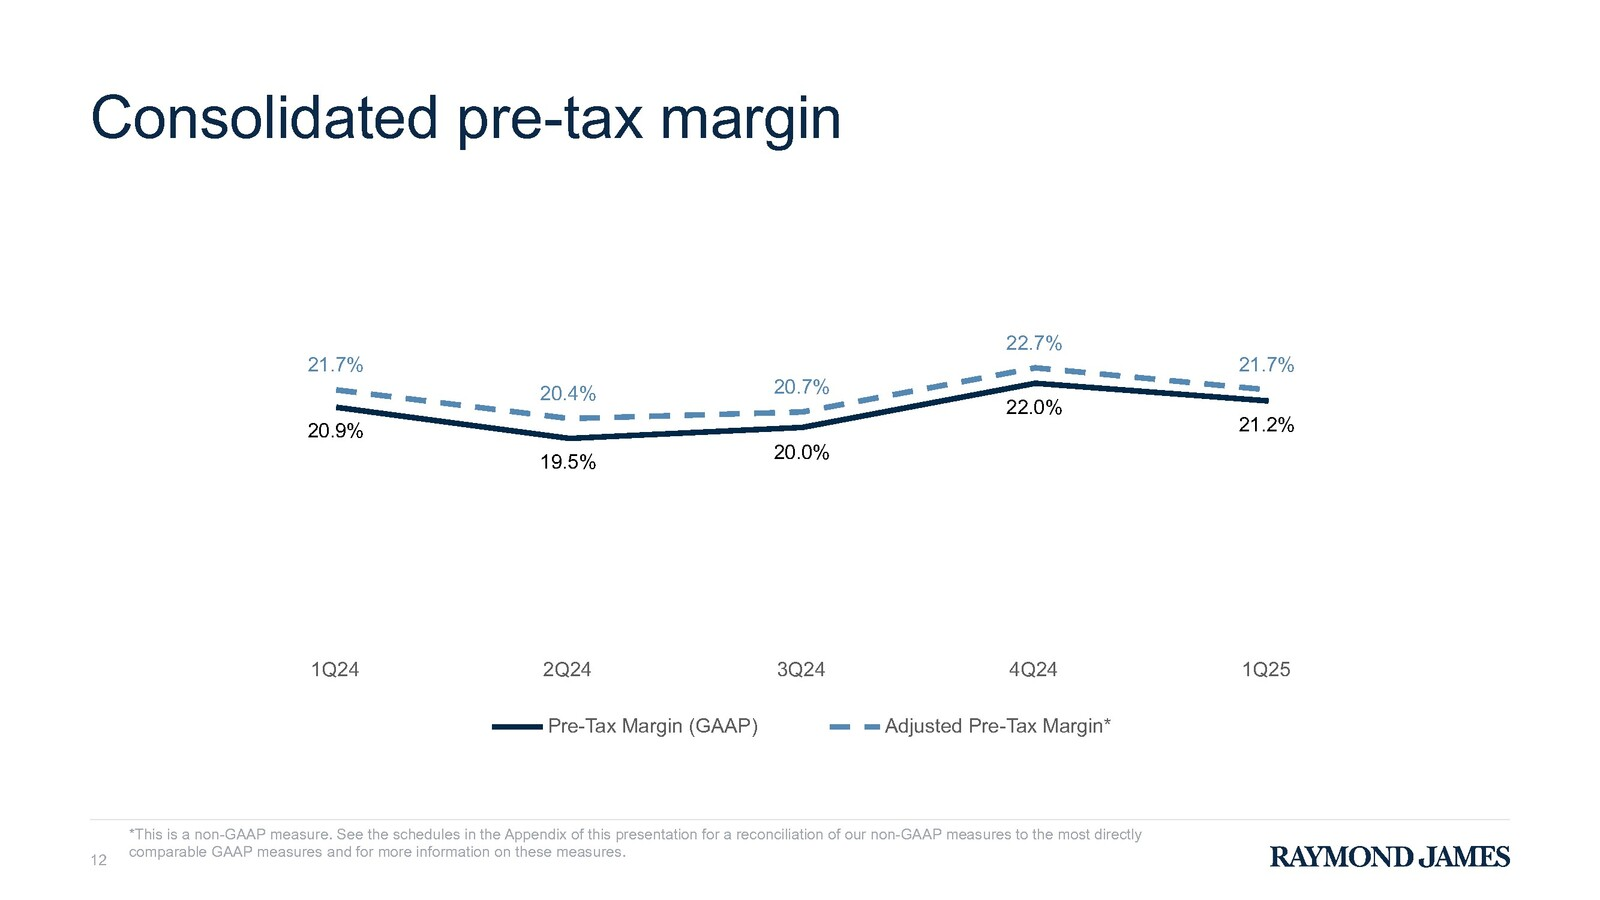

In terms of pre-tax income, the Private Client Group reported $462 million, a 5% increase from 1Q24. The Capital Markets segment saw a dramatic increase in pre-tax income to $74 million, up 2,367% from 1Q24, although it decreased by 22% from 4Q24. Asset Management achieved a record pre-tax income of $125 million, a 34% increase from 1Q24 and an 8% increase from 4Q24. The Bank segment's pre-tax income was $118 million, reflecting a 28% increase from 1Q24 and a 20% increase from 4Q24.

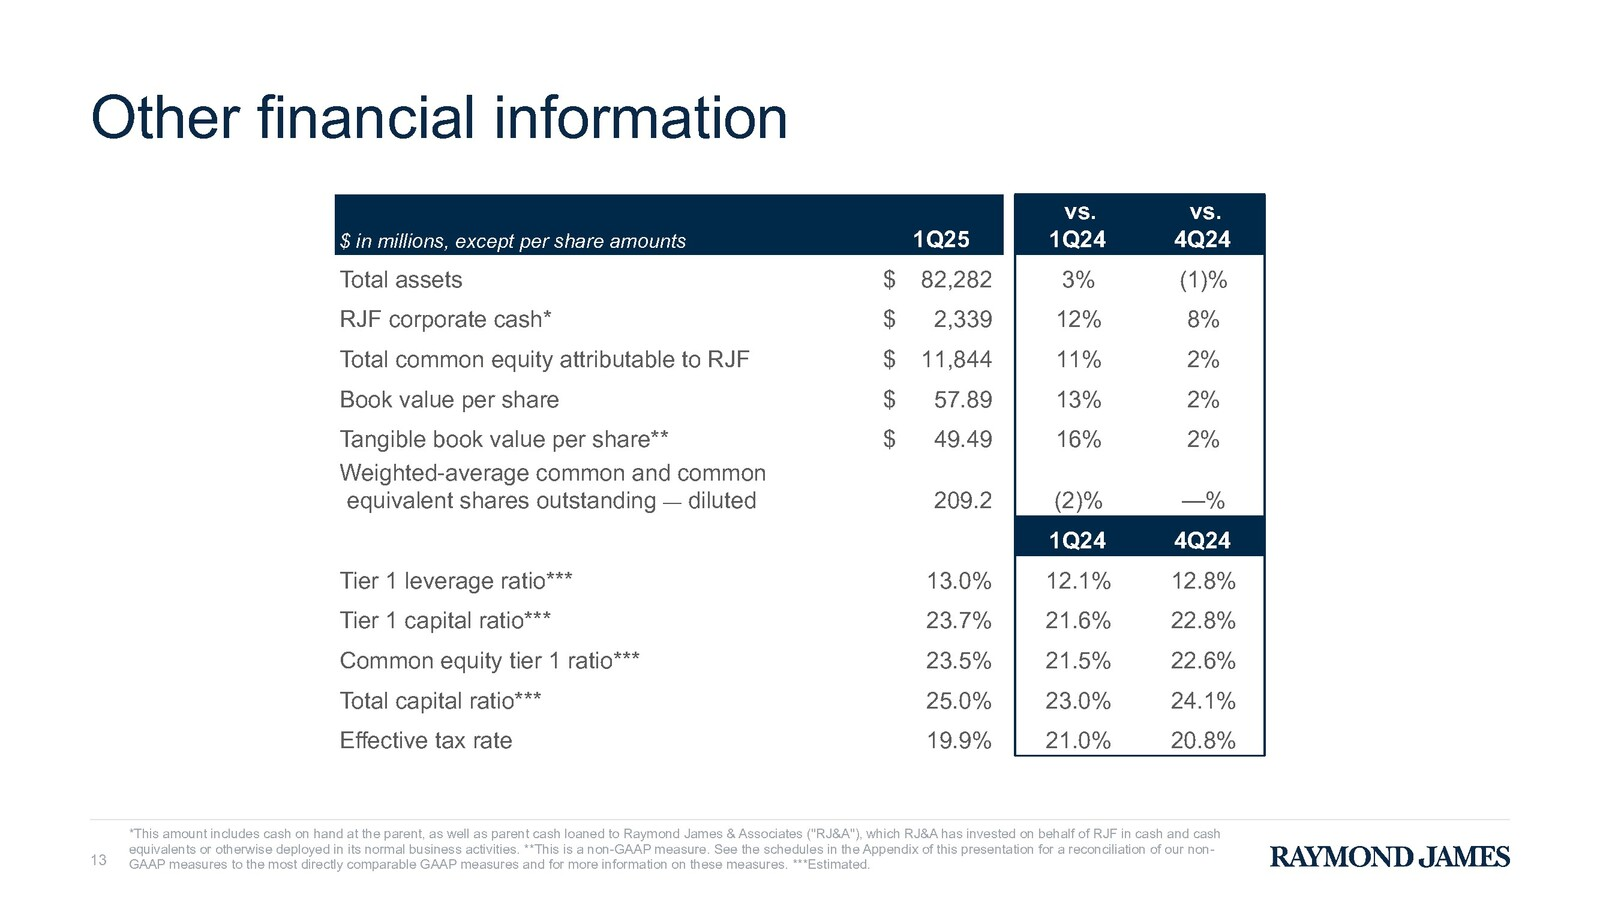

Overall, the consolidated net revenues reached a record $3,537 million, a 17% increase from 1Q24 and a 2% increase from 4Q24. The consolidated pre-tax income was $749 million, a 19% increase from 1Q24, although it saw a slight decrease of 1% from 4Q24.

CPU times: total: 422 ms
Wall time: 21.5 s


In [13]:
%%time
query_engine = index.as_query_engine(
    #number of similar results to consider during the query
    similarity_top_k=10,
    llm=sllm,
    # response_mode="tree_summarize"
    response_mode="compact",
)

response = query_engine.query(
    "Give me a summary of the financial performance of the different business units"
)

response.response.render()

Raymond James Financial, Inc. reported strong financial results for the fiscal first quarter of 2025, with record quarterly net revenues of $3.54 billion, marking a 17% increase over the prior year and a 2% increase over the preceding quarter. The company also achieved a quarterly net income available to common shareholders of $599 million, or $2.86 per diluted share, with adjusted net income reaching $614 million, or $2.93 per diluted share.

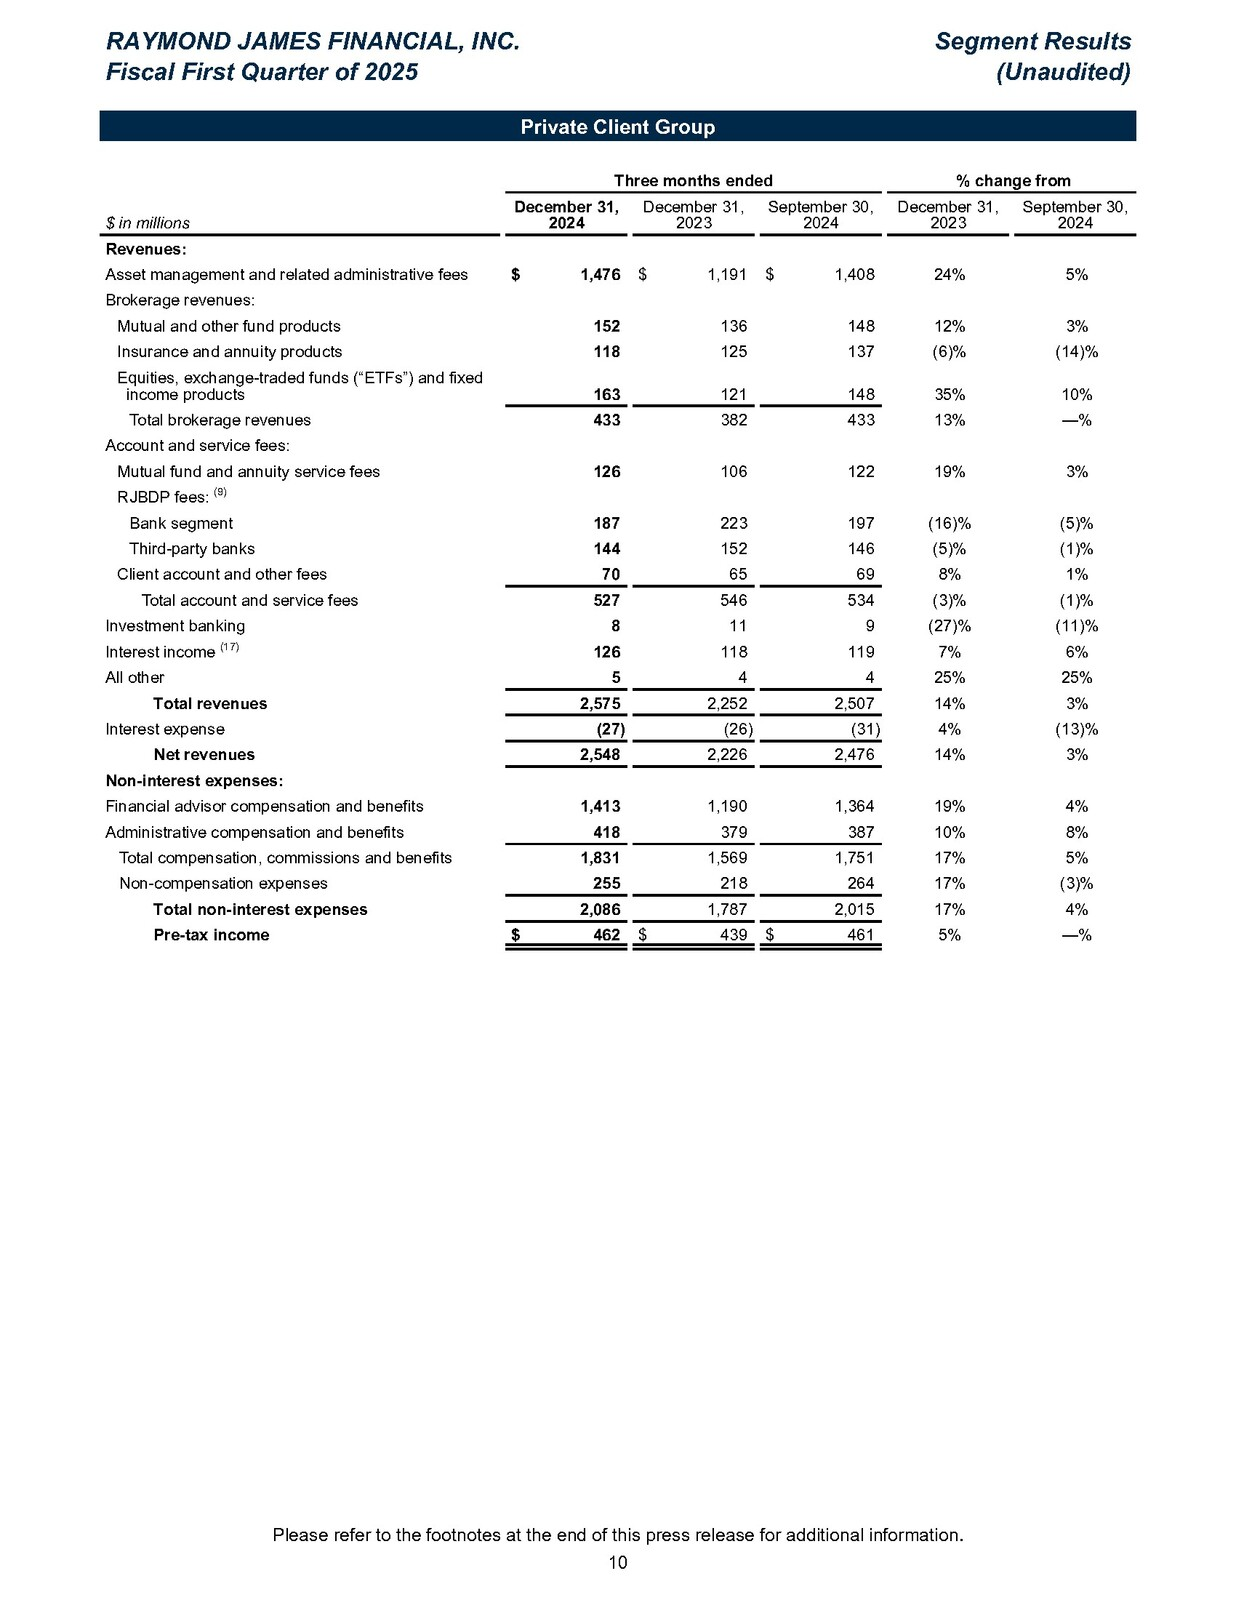

The Private Client Group segment reported record quarterly net revenues of $2.55 billion, up 14% year-over-year, driven by higher asset management and related administrative fees. The Capital Markets segment saw a significant 42% increase in quarterly net revenues compared to the previous year, primarily due to robust investment banking growth.

Asset Management also reported record quarterly net revenues of $294 million, a 25% increase over the prior year, supported by higher financial assets under management. The Bank segment, however, experienced a 4% decline in quarterly net revenues compared to the previous year, although pre-tax income increased by 28% due to a lower bank loan provision for credit losses.

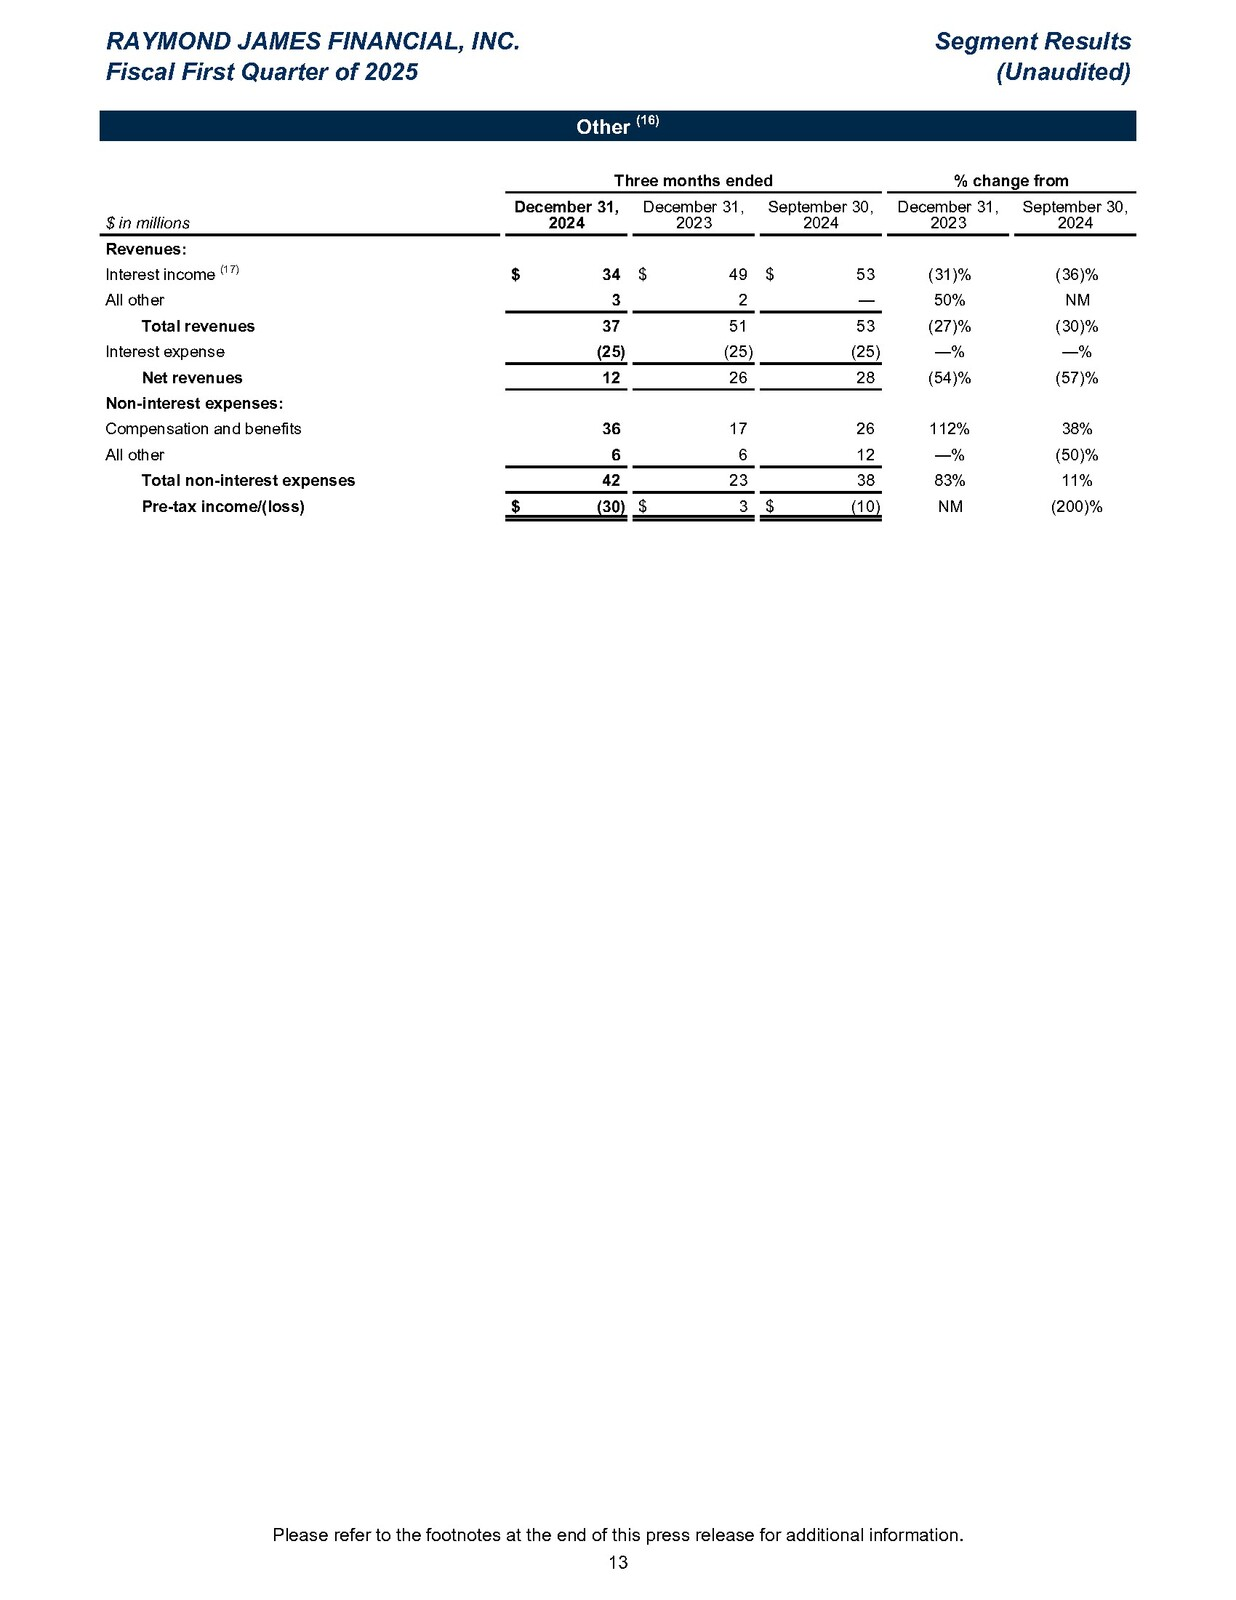

Overall, Raymond James Financial's financial projections appear stable, with strong growth in key segments such as Private Client Group and Capital Markets. However, potential risk factors include the decline in net revenues for the Bank segment and the impact of seasonal headwinds mentioned by the CEO. Additionally, the departure of a large independent branch could affect asset levels in the Private Client Group.

In [73]:
# Trying another query
response = query_engine.query(
    "Give me a summary of whether you think the financial projections are stable, and if not, what are the potential risk factors. "
    "Support your research with sources."
)

response.response.render()

The net interest income for Raymond James Financial, Inc. for the fiscal first quarter of 2025 was $529 million. This represents a decrease compared to the previous quarter, which was $532 million, and a decrease from the previous year's same quarter, which was $546 million.

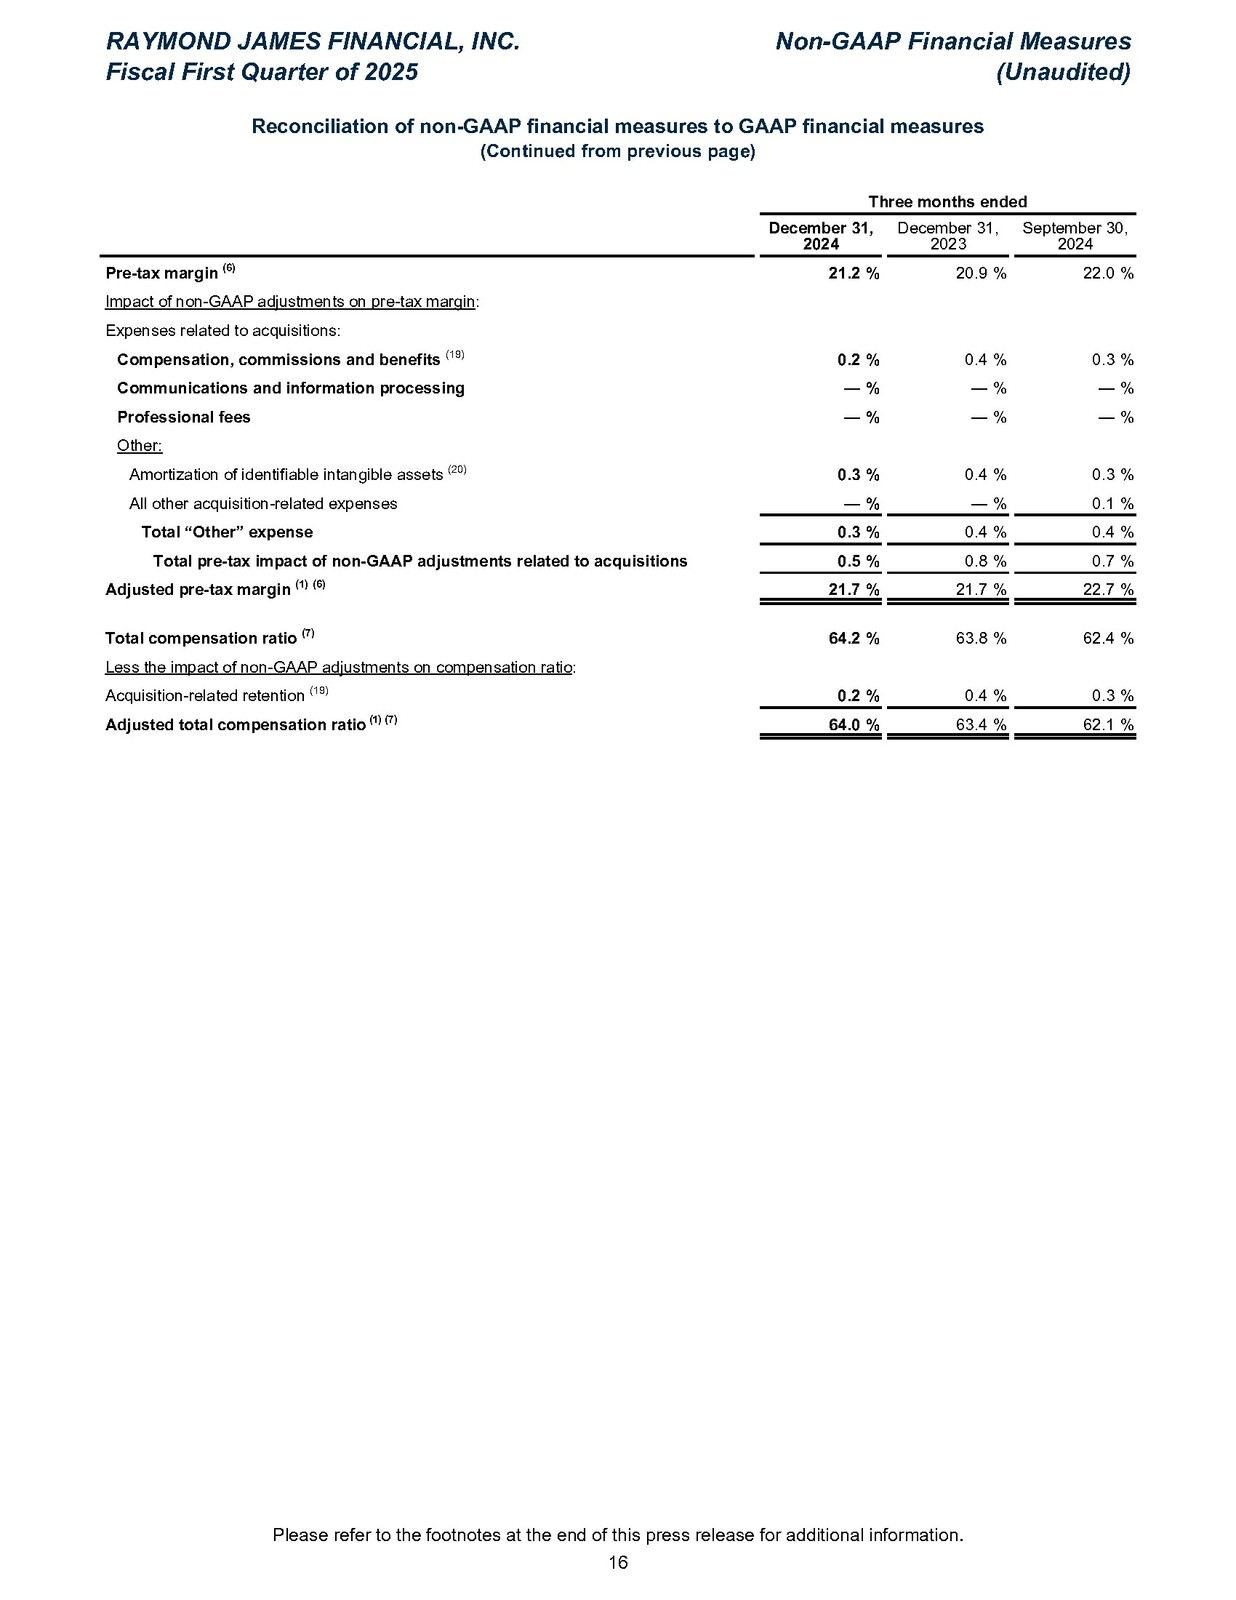

In [75]:
# Trying another query
response = query_engine.query(
    "What is the Net Interest Income for the current quarter? How does it compare to the previous quarter and the previous year? "
    "Support your research with sources."
)

response.response.render()